# Unit 3: Lesson 5: Project 3: Gradient Boost Model Drill with European Social Survey Data

### Eva Rubin
#### Dec 2018

In [509]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

### Thinkful Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [510]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno', 'year'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [517]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17539552645935624

Test set accuracy:
Percent Type I errors: 0.05766871165644172
Percent Type II errors: 0.19263803680981595


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

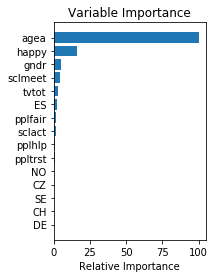

In [518]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

## DRILL: Improve the gradient boost model

Will try:

* Applying more overfitting-prevention strategies like subsampling
* Changing iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications
* Creating new features


## Define Modified Outcome and Predictors, and Model:

Explanations and function comes from:
- https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

Check out:

- https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn
- https://stats.stackexchange.com/questions/173390/gradient-boosting-tree-vs-random-forest

In [520]:
# Define modified outcome and predictors.
# Set our outcome to 0 and 1.
y2 = df['partner'] - 1
X2 = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'year', 'idno'])]

# Make the categorical variable 'country' into dummies.
X2 = pd.concat([X2, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets
offset2 = int(X2.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train2, y_train2 = X2[:offset], y2[:offset]

# And put 30% in the test set.
X_test2, y_test2 = X2[offset:], y2[offset:]

In [580]:
def modelfit(alg, df, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    #Fit the algorithm on the data
    alg.fit(X_train2, y_train2)
        
    #Predict training set:
    df_predictions = alg.predict(X_train2)
    df_predprob = alg.predict_proba(X_train2)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train2, y_train2, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train2.values, df_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train2, df_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    

## Baseline Model


Model Report
Accuracy : 0.7771
AUC Score (Train): 0.823648
CV Score : Mean - 0.7745918 | Std - 0.02375653 | Min - 0.7294155 | Max - 0.7959507


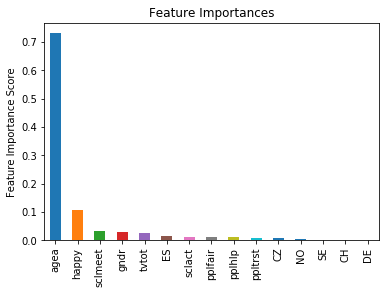

In [522]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train2.columns if x not in df[['partner', 'cntry', 'year', 'idno']]]

gbm0 = ensemble.GradientBoostingClassifier(random_state=10)
modelfit(gbm0, df, predictors)


## Get optimum number of trees for learning rate of .1

Starting from 30 trees, test every 2 trees up to 81.  Result is that 78 trees is optimal for learing rate of .1

- First tested with wider range and then narrowed as honed in on best n_estimator.

### learning_rate:
- This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates.
- Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well.
- Lower values would require higher number of trees to model all the relations and will be computationally expensive.

### Fix learning rate and number of estimators for tuning tree-based parameters
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

- min_samples_split = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
- min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
- max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
- max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
- subsample = 0.8 : This is a commonly used used start value


Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees for that. For this purpose, we can do a grid search and test out values from 20 to 80 in steps of 10.


In [574]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train2.columns if x not in df[['partner', 'cntry', 'year', 'idno']]]

param_test1 = {'n_estimators':range(30,81,2)}

gsearch1 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=500,min_samples_leaf=50,
                                                               max_depth=8,max_features='sqrt',subsample=0.8,
                                                               random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train2, y_train2)
gsearch1.best_estimator_, gsearch1.best_params_, gsearch1.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=8,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=50, min_samples_split=500,
               min_weight_fraction_leaf=0.0, n_estimators=78,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'n_estimators': 78},
 0.7874483491406059)

## Tune Tree Specific Parameters

- Tune max_depth and num_samples_split
- Tune min_samples_leaf
- Tune max_features

The order of tuning variables should be decided carefully. You should take the variables with a higher impact on outcome first. For instance, max_depth and min_samples_split have a significant impact and we’re tuning those first.

You can vary the number of values you are testing based on what your system can handle.

To start with, test max_depth values of 5 to 15 in steps of 2 and min_samples_split from 200 to 1000 in steps of 200. You can set wider ranges as well and then perform multiple iterations for smaller ranges.


In [583]:
# max depth and num_samples_split
param_test2 = {'max_depth':range(1,8,1), 'min_samples_split':range(400,801,100)}
gsearch2 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=78,
                                                                        max_features='sqrt', subsample=0.8,
                                                                        random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train2, y_train2)
gsearch2.best_estimator_, gsearch2.best_params_, gsearch2.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=2,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=600,
               min_weight_fraction_leaf=0.0, n_estimators=78,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'max_depth': 2, 'min_samples_split': 600},
 0.779032358790924)

In [584]:
param_test3 = {'min_samples_split':range(500,701,25), 'min_samples_leaf':range(1,8,1)}
gsearch3 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=78,max_depth=2,
                                                               max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train2, y_train2)
gsearch3.best_estimator_, gsearch3.best_params_, gsearch3.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=2,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=600,
               min_weight_fraction_leaf=0.0, n_estimators=78,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'min_samples_leaf': 1, 'min_samples_split': 600},
 0.779032358790924)


Model Report
Accuracy : 0.7535
AUC Score (Train): 0.795953
CV Score : Mean - 0.7790324 | Std - 0.02791092 | Min - 0.7320733 | Max - 0.8161961


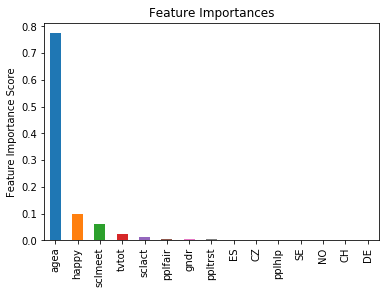

In [585]:
modelfit(gsearch3.best_estimator_, df, predictors)

In [702]:
# We'll make 78 iterations, use 2-deep trees, and set our loss function.
# https://machinelearningmastery.com/configure-gradient-boosting-algorithm/
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

params2 = {'criterion':'friedman_mse',
           'init': None,
           'learning_rate': 0.1,
           'loss': 'deviance',
           'max_depth': 2,
            'max_features': 'sqrt',
           'max_leaf_nodes': None,
           'min_impurity_decrease': 0.0, 'min_impurity_split': None,
            'min_samples_leaf': 1, 'min_samples_split': 600,
            'min_weight_fraction_leaf': 0.0, 'n_estimators': 78,
            'n_iter_no_change': None, 'presort': 'auto', 'random_state': 10,
            'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1,
             'verbose': 0, 'warm_start': False}

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params2)
clf2.fit(X_train2, y_train2)

predict_train2 = clf2.predict(X_train2)
predict_test2 = clf2.predict(X_test2)

# Accuracy tables.
table_train2 = pd.crosstab(y_train2, predict_train2, margins=True)
table_test2 = pd.crosstab(y_test2, predict_test2, margins=True)

train_tI_errors2 = table_train2.loc[0.0,1.0] / table_train2.loc['All','All']
train_tII_errors2 = table_train2.loc[1.0,0.0] / table_train2.loc['All','All']

test_tI_errors2 = table_test2.loc[0.0,1.0]/table_test2.loc['All','All']
test_tII_errors2 = table_test2.loc[1.0,0.0]/table_test2.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors  (False POS): {}\n'
    'Percent Type II errors (False NEG): {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors  (False POS): {}\n'
    'Percent Type II errors (False NEG): {}'
).format(train_tI_errors2, train_tII_errors2, test_tI_errors2, test_tII_errors2))


Training set accuracy:
Percent Type I errors  (False POS): 0.03409710856519367
Percent Type II errors (False NEG): 0.2123567921440262

Test set accuracy:
Percent Type I errors  (False POS): 0.046625766871165646
Percent Type II errors (False NEG): 0.2184049079754601


## Tune max_features
check out:
https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

In [712]:

param_test3a = {'max_features': (.5, .6, .7, .75, .8, .9)}

gsearch3a = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=78,max_depth=2, 
                                                                min_samples_split=600, min_samples_leaf=1, subsample=0.8, 
                                                                random_state=10),
param_grid = param_test3a, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3a.fit(X_train2, y_train2)
gsearch3a.best_estimator_, gsearch3a.best_params_, gsearch3a.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=2,
               max_features=0.75, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=600,
               min_weight_fraction_leaf=0.0, n_estimators=78,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'max_features': 0.75},
 0.7806901467260483)


Model Report
Accuracy : 0.7595
AUC Score (Train): 0.800225
CV Score : Mean - 0.7806901 | Std - 0.02834367 | Min - 0.7294547 | Max - 0.8137109


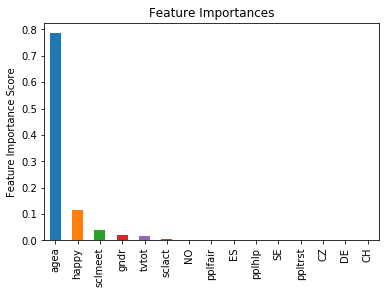

In [713]:
modelfit(gsearch3a.best_estimator_, df, predictors)

## Tune Subsampling

In [714]:

param_test3b = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

gsearch3b = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=78,max_depth=2, 
                                                                min_samples_split=600, min_samples_leaf=1, subsample=0.8, 
                                                                random_state=10, max_features=.75),
param_grid = param_test3b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3b.fit(X_train2, y_train2)
gsearch3b.best_estimator_, gsearch3b.best_params_, gsearch3b.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=2,
               max_features=0.75, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=600,
               min_weight_fraction_leaf=0.0, n_estimators=78,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.75, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'subsample': 0.75},
 0.7822589324042785)


Model Report
Accuracy : 0.7602
AUC Score (Train): 0.800898
CV Score : Mean - 0.7822589 | Std - 0.02986709 | Min - 0.7312393 | Max - 0.8221249


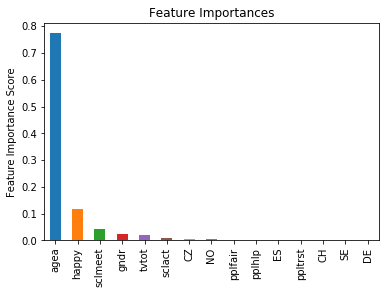

In [715]:
modelfit(gsearch3b.best_estimator_, df, predictors)

### While max_features and subsample parameters increased accuracy and cross validation scores, it seems to have increased Type I and Type II errors again.

Will continue with tuning parameters for purposes of challenge.

In [716]:
# We'll make 78 iterations, use 4-deep trees, and set our loss function.
# https://machinelearningmastery.com/configure-gradient-boosting-algorithm/
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

params2 = {'criterion':'friedman_mse',
           'init': None,
           'learning_rate': 0.1,
           'loss': 'deviance',
           'max_depth': 2,
           'max_features': .75,
           'max_leaf_nodes': None,
           'min_impurity_decrease': 0.0, 'min_impurity_split': None,
            'min_samples_leaf': 1, 'min_samples_split': 600,
            'min_weight_fraction_leaf': 0.0, 'n_estimators': 78,
            'n_iter_no_change': None, 'presort': 'auto', 'random_state': 10,
            'subsample': 0.75, 'tol': 0.0001, 'validation_fraction': 0.1,
             'verbose': 0, 'warm_start': False}

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params2)
clf2.fit(X_train2, y_train2)

predict_train2 = clf2.predict(X_train2)
predict_test2 = clf2.predict(X_test2)

# Accuracy tables.
table_train2 = pd.crosstab(y_train2, predict_train2, margins=True)
table_test2 = pd.crosstab(y_test2, predict_test2, margins=True)

train_tI_errors2 = table_train2.loc[0.0,1.0] / table_train2.loc['All','All']
train_tII_errors2 = table_train2.loc[1.0,0.0] / table_train2.loc['All','All']

test_tI_errors2 = table_test2.loc[0.0,1.0]/table_test2.loc['All','All']
test_tII_errors2 = table_test2.loc[1.0,0.0]/table_test2.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors  (False POS): {}\n'
    'Percent Type II errors (False NEG): {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors  (False POS): {}\n'
    'Percent Type II errors (False NEG): {}'
).format(train_tI_errors2, train_tII_errors2, test_tI_errors2, test_tII_errors2))

Training set accuracy:
Percent Type I errors  (False POS): 0.04132569558101473
Percent Type II errors (False NEG): 0.19844517184942717

Test set accuracy:
Percent Type I errors  (False POS): 0.05276073619631902
Percent Type II errors (False NEG): 0.2098159509202454


## Decrease learning rate and increase number of trees proportionally


Model Report
Accuracy : 0.7609
AUC Score (Train): 0.800235
CV Score : Mean - 0.781693 | Std - 0.02861834 | Min - 0.7305025 | Max - 0.816562


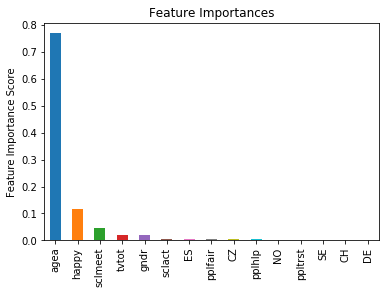

In [718]:
                      
predictors = [x for x in X_train2.columns if x not in df[['partner', 'cntry', 'year', 'idno']]]
gbm_tuned_1 = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=156,max_depth=2,
                                                               max_features=.75, subsample=0.75, random_state=10)
modelfit(gbm_tuned_1, df, predictors)


### If learning_rate is .05 and max_features (.75) and subsample (.75) parameters are used as identified best parameters, Type I and Type II errors are not reduced:

**learning_rate is .05 and max_features (.75) and subsample (.75):**
Training set accuracy:
Percent Type I errors  (False POS): 0.04187124931805783
Percent Type II errors (False NEG): 0.19939989088925258

Test set accuracy:
Percent Type I errors  (False POS): 0.053987730061349694
Percent Type II errors (False NEG): 0.2098159509202454

**learning_rate is .05 and max_features (sqrt) and subsample (.8):**
Training set accuracy:
Percent Type I errors  (False POS): 0.03314238952536825
Percent Type II errors (False NEG): 0.2133115111838516

Test set accuracy:
Percent Type I errors  (False POS): 0.044171779141104296
Percent Type II errors (False NEG): 0.2134969325153374


In [735]:
# We'll make 156 iterations, use 2-deep trees, and set our loss function.
# https://machinelearningmastery.com/configure-gradient-boosting-algorithm/
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

params2 = {'criterion':'friedman_mse',
           'init': None,
           'learning_rate': 0.05,
           'loss': 'deviance',
           'max_depth': 2,
            'max_features': 'sqrt',
           'max_leaf_nodes': None,
           'min_impurity_decrease': 0.0, 'min_impurity_split': None,
            'min_samples_leaf': 1, 'min_samples_split': 600,
            'min_weight_fraction_leaf': 0.0, 'n_estimators': 156,
            'n_iter_no_change': None, 'presort': 'auto', 'random_state': 10,
            'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1,
             'verbose': 0, 'warm_start': False}

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params2)
clf2.fit(X_train2, y_train2)

predict_train2 = clf2.predict(X_train2)
predict_test2 = clf2.predict(X_test2)

# Accuracy tables.
table_train2 = pd.crosstab(y_train2, predict_train2, margins=True)
table_test2 = pd.crosstab(y_test2, predict_test2, margins=True)

train_tI_errors2 = table_train2.loc[0.0,1.0] / table_train2.loc['All','All']
train_tII_errors2 = table_train2.loc[1.0,0.0] / table_train2.loc['All','All']

test_tI_errors2 = table_test2.loc[0.0,1.0]/table_test2.loc['All','All']
test_tII_errors2 = table_test2.loc[1.0,0.0]/table_test2.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors  (False POS): {}\n'
    'Percent Type II errors (False NEG): {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors  (False POS): {}\n'
    'Percent Type II errors (False NEG): {}'
).format(train_tI_errors2, train_tII_errors2, test_tI_errors2, test_tII_errors2))


Training set accuracy:
Percent Type I errors  (False POS): 0.03314238952536825
Percent Type II errors (False NEG): 0.2133115111838516

Test set accuracy:
Percent Type I errors  (False POS): 0.044171779141104296
Percent Type II errors (False NEG): 0.2134969325153374


## Will test out how adding additional features according to age affects accuracy

Since very young people are probably less likely to have gotten married yet and very old people are likely to have lost their spouse, will test to see if catgories of age are better predictors of having a partner.

- will create categories of age by 10 year blocks

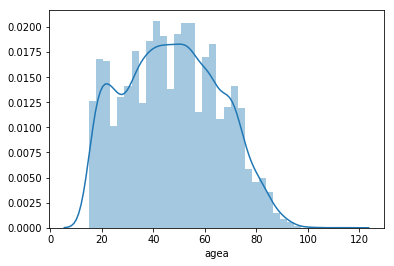

In [529]:
# Check out distribution of age.
sns.distplot(df['agea']);

In [599]:
# Note: am unsure of coding meaning since ESS does not match the categories of 1 and 2. For purposes of assignment,
# guessing that 1 = partner and 2 = no partner
# https://medium.com/@msalmon00/helpful-python-code-snippets-for-data-exploration-in-pandas-b7c5aed5ecb9

# Get age stats by partner categories
df.groupby('partner').agea.describe()

# https://stackoverflow.com/questions/17679089/pandas-dataframe-groupby-two-columns-and-get-counts
#partner_status_by_age = df_age_breakdown.groupby(['partner', 'agea_under_20', 'agea_20_29', 'agea_30_39', 'agea_40_49', 'agea_50_59', 'agea_60_69', 'agea_70_79', 'agea_80_89']).size()

,count,mean,std,min,25%,50%,75%,max
partner,,,,,,,,
1.0,5013.0,50.979254,14.954612,18.0,39.0,50.0,62.0,95.0
2.0,3134.0,41.316528,21.380044,15.0,22.0,36.0,58.0,114.0


In [537]:
df_age_breakdown = df

In [538]:
df_age_breakdown['agea_under_20'] = np.where(df['agea'] < 20, 1, 0)
df_age_breakdown['agea_20_29'] = np.where(((df['agea'] >= 20) & (df['agea'] < 30)), 1, 0)
df_age_breakdown['agea_30_39'] = np.where(((df['agea'] >= 30) & (df['agea'] < 40)), 1, 0)
df_age_breakdown['agea_40_49'] = np.where(((df['agea'] >= 40) & (df['agea'] < 50)), 1, 0)
df_age_breakdown['agea_50_59'] = np.where(((df['agea'] >= 50) & (df['agea'] < 60)), 1, 0)
df_age_breakdown['agea_60_69'] = np.where(((df['agea'] >= 60) & (df['agea'] < 70)), 1, 0)
df_age_breakdown['agea_70_79'] = np.where(((df['agea'] >= 70) & (df['agea'] < 80)), 1, 0)
df_age_breakdown['agea_80_89'] = np.where(((df['agea'] >= 80) & (df['agea'] < 90)), 1, 0)
df_age_breakdown['agea_90_99'] = np.where(((df['agea'] >= 90) & (df['agea'] < 100)), 1, 0)
df_age_breakdown['agea_over_100'] = np.where(df['agea'] > 99, 1, 0)

In [539]:
df_age_breakdown.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,...,agea_under_20,agea_20_29,agea_30_39,agea_40_49,agea_50_59,agea_60_69,agea_70_79,agea_80_89,agea_90_99,agea_over_100
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,...,0,0,0,0,0,1,0,0,0,0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,...,0,0,0,0,1,0,0,0,0,0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,...,0,1,0,0,0,0,0,0,0,0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,...,0,0,0,0,0,1,0,0,0,0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,...,0,0,0,0,1,0,0,0,0,0


In [608]:
# See age categories by partner status
df_age_by_partner_cat = df_age_breakdown[['partner', 'agea_under_20', 'agea_20_29', 'agea_30_39', 'agea_40_49','agea_50_59', 'agea_60_69', 'agea_70_79', 'agea_80_89', 'agea_90_99', 'agea_over_100' ]]
df_age_by_partner_cat.groupby(by=['partner']).sum()



,agea_under_20,agea_20_29,agea_30_39,agea_40_49,agea_50_59,agea_60_69,agea_70_79,agea_80_89,agea_90_99,agea_over_100
partner,,,,,,,,,,
1.0,7,347,916,1151,1069,865,525,121,12,0
2.0,541,756,389,350,350,324,240,156,25,3


In [606]:
# Since there seem to be 2 natural categories of single/partnered according to age
# will create these cats now (single = under 30 and 80 and over; partnered = 31 yrs - 79 yrs)

df_age_breakdown['agea_single'] = np.where(((df['agea'] < 30) & (df['agea'] > 79)), 1, 0)
df_age_breakdown['agea_partnered'] = np.where(((df['agea'] >= 30) & (df['agea'] <= 79)), 1, 0)


## New baseline - with added features of age categories

In [743]:
# Definine modified outcome and predictors.
# Set our outcome to 0 and 1.
y3 = df_age_breakdown['partner'] - 1
X3 = df_age_breakdown.loc[:, ~df_age_breakdown.columns.isin(['partner', 'cntry', 'year', 'idno', 'agea_single', 'agea_under_20', 'agea_20_29', 'agea_30_39', 'agea_40_49', 'agea_50_59', 'agea_60_69', 'agea_70_79', 'agea_80_89', 'agea_90_99', 'agea_over_100'])]

# Remove categorical variable 'country' into dummies.
#X3 = pd.concat([X3, pd.get_dummies(df_age_breakdown['cntry'])], axis=1)

# Create training and test sets
offset2 = int(X3.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train3, y_train3 = X3[:offset], y3[:offset]

# And put 30% in the test set.
X_test3, y_test3 = X3[offset:], y3[offset:]


In [744]:
def modelfit2(alg, df, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    #Fit the algorithm on the data
    alg.fit(X_train3, y_train3)
        
    #Predict training set:
    df_predictions = alg.predict(X_train3)
    df_predprob = alg.predict_proba(X_train3)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train3, y_train3, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train3.values, df_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train3, df_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## Baseline with added feature: agea_partnered


Model Report
Accuracy : 0.7743
AUC Score (Train): 0.819140
CV Score : Mean - 0.7860727 | Std - 0.02064709 | Min - 0.7540883 | Max - 0.8149981


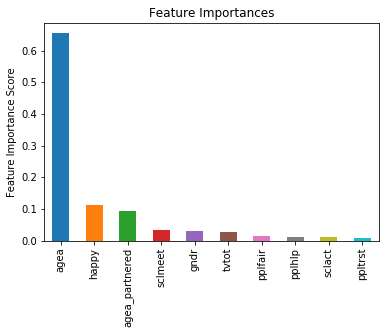

In [745]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train3.columns if x not in df_age_breakdown[['partner', 'cntry', 'year', 'idno', 'agea_single', 'agea_under_20', 'agea_20_29', 'agea_30_39', 'agea_40_49', 'agea_50_59', 'agea_60_69', 'agea_70_79', 'agea_80_89', 'agea_90_99', 'agea_over_100']]]

gbm000 = ensemble.GradientBoostingClassifier(random_state=10)
modelfit2(gbm000, df_age_breakdown, predictors)

In [746]:
#Choose all predictors except target & IDcols
predictors = [x for x in df_age_breakdown.columns if x not in df_age_breakdown[['partner', 'cntry', 'idno', 'year', 'agea_single', 'agea_under_20', 'agea_20_29', 'agea_30_39', 'agea_40_49', 'agea_50_59', 'agea_60_69', 'agea_70_79', 'agea_80_89', 'agea_90_99', 'agea_over_100']]]

param_test4 = {'n_estimators':range(80,111,2)}

gsearch4 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=500,min_samples_leaf=50,
                                                               max_depth=8,max_features='sqrt',subsample=0.8,
                                                               random_state=10), 
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch4.fit(X_train3, y_train3)
gsearch4.best_estimator_, gsearch4.best_params_, gsearch4.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=8,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=50, min_samples_split=500,
               min_weight_fraction_leaf=0.0, n_estimators=92,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'n_estimators': 92},
 0.7834158164105284)

## Tune Tree Specific Parameters
- Tune max_depth and num_samples_split
- Tune min_samples_leaf
- Tune max_features

In [747]:
# max depth and num_samples_split
param_test5 = {'max_depth':range(1,12,1), 'min_samples_split':range(2, 201,25)}
gsearch5 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=92,
                                                                        max_features='sqrt', subsample=0.8,
                                                                        random_state=10), 
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch5.fit(X_train3, y_train3)
gsearch5.best_estimator_, gsearch5.best_params_, gsearch5.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=92,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'max_depth': 3, 'min_samples_split': 2},
 0.7861947035045708)

In [750]:
param_test6= {'min_samples_split':range(7,10,1), 'min_samples_leaf':range(1,6,1)}
gsearch6 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=92,max_depth=3,
                                                               max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch6.fit(X_train3, y_train3)
gsearch6.best_estimator_, gsearch6.best_params_, gsearch6.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=8,
               min_weight_fraction_leaf=0.0, n_estimators=92,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'min_samples_leaf': 1, 'min_samples_split': 8},
 0.7867972936928277)


Model Report
Accuracy : 0.7662
AUC Score (Train): 0.811564
CV Score : Mean - 0.7867973 | Std - 0.02118536 | Min - 0.75519 | Max - 0.8172144


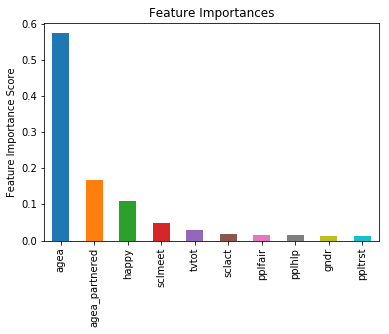

In [751]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train3.columns if x not in df_age_breakdown[['partner', 'cntry', 'year', 'idno', 'agea_single', 'agea_under_20', 'agea_20_29', 'agea_30_39', 'agea_40_49', 'agea_50_59', 'agea_60_69', 'agea_70_79', 'agea_80_89', 'agea_90_99', 'agea_over_100']]]

modelfit2(gsearch6.best_estimator_, df_age_breakdown, predictors)

## Tune Max Features

In [758]:
param_test6a = {'max_features': (.5, .6, .7, .75, .8, .9)}

gsearch6a = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=92,max_depth=3, 
                                                                min_samples_split=8, min_samples_leaf=1, subsample=0.8, 
                                                                random_state=10),
param_grid = param_test6a, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6a.fit(X_train3, y_train3)
gsearch6a.best_estimator_, gsearch6a.best_params_, gsearch6a.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=0.6, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=8,
               min_weight_fraction_leaf=0.0, n_estimators=92,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'max_features': 0.6},
 0.787089690881408)


Model Report
Accuracy : 0.7728
AUC Score (Train): 0.817651
CV Score : Mean - 0.7870897 | Std - 0.02041775 | Min - 0.7539568 | Max - 0.8147185


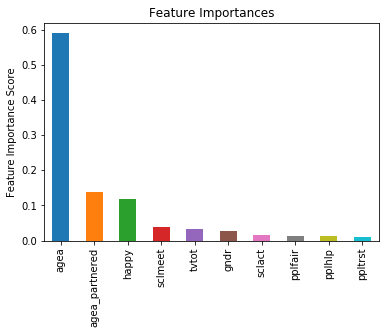

In [760]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train3.columns if x not in df_age_breakdown[['partner', 'cntry', 'year', 'idno', 'agea_single', 'agea_under_20', 'agea_20_29', 'agea_30_39', 'agea_40_49', 'agea_50_59', 'agea_60_69', 'agea_70_79', 'agea_80_89', 'agea_90_99', 'agea_over_100']]]

modelfit2(gsearch6a.best_estimator_, df_age_breakdown, predictors)

## Tune Subsampling

In [761]:

param_test6b = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

gsearch6b = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=0.6, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=8,
               min_weight_fraction_leaf=0.0, n_estimators=92,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
param_grid = param_test6b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6b.fit(X_train3, y_train3)
gsearch6b.best_estimator_, gsearch6b.best_params_, gsearch6b.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=0.6, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=8,
               min_weight_fraction_leaf=0.0, n_estimators=92,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'subsample': 0.8},
 0.787089690881408)


Model Report
Accuracy : 0.7728
AUC Score (Train): 0.817651
CV Score : Mean - 0.7870897 | Std - 0.02041775 | Min - 0.7539568 | Max - 0.8147185


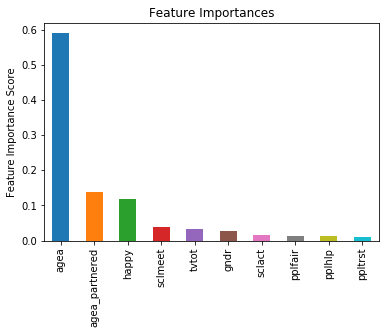

In [763]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train3.columns if x not in df_age_breakdown[['partner', 'cntry', 'year', 'idno', 'agea_single', 'agea_under_20', 'agea_20_29', 'agea_30_39', 'agea_40_49', 'agea_50_59', 'agea_60_69', 'agea_70_79', 'agea_80_89', 'agea_90_99', 'agea_over_100']]]

modelfit2(gsearch6b.best_estimator_, df_age_breakdown, predictors)

In [766]:
# We'll make 76 iterations, use 4-deep trees, and set our loss function.
# https://machinelearningmastery.com/configure-gradient-boosting-algorithm/
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

params3 = {'criterion':'friedman_mse',
           'init': None,
           'learning_rate': 0.1,
           'loss': 'deviance',
           'max_depth': 3,
           'max_features':.6,
           'max_leaf_nodes': None,
           'min_impurity_decrease': 0.0, 'min_impurity_split': None,
            'min_samples_leaf': 1, 'min_samples_split': 8,
            'min_weight_fraction_leaf': 0.0, 'n_estimators': 92,
            'n_iter_no_change': None, 'presort': 'auto', 'random_state': 10,
            'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1,
             'verbose': 0, 'warm_start': False}

# Initialize and fit the model.
clf3 = ensemble.GradientBoostingClassifier(**params3)
clf3.fit(X_train3, y_train3)

predict_train3 = clf3.predict(X_train3)
predict_test3 = clf3.predict(X_test3)

# Accuracy tables.
table_train3 = pd.crosstab(y_train3, predict_train3, margins=True)
table_test3 = pd.crosstab(y_test, predict_test3, margins=True)

train_tI_errors3 = table_train3.loc[0.0,1.0] / table_train3.loc['All','All']
train_tII_errors3 = table_train3.loc[1.0,0.0] / table_train3.loc['All','All']

test_tI_errors3 = table_test3.loc[0.0,1.0]/table_test3.loc['All','All']
test_tII_errors3 = table_test3.loc[1.0,0.0]/table_test3.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors  (False POS): {}\n'
    'Percent Type II errors (False NEG): {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors  (False POS): {}\n'
    'Percent Type II errors (False NEG): {}'
).format(train_tI_errors3, train_tII_errors3, test_tI_errors3, test_tII_errors3))


Training set accuracy:
Percent Type I errors  (False POS): 0.04459901800327332
Percent Type II errors (False NEG): 0.1891707583196945

Test set accuracy:
Percent Type I errors  (False POS): 0.06012269938650307
Percent Type II errors (False NEG): 0.2


## Decrease learning rate and increase number of trees proportionally


Model Report
Accuracy : 0.7714
AUC Score (Train): 0.817658
CV Score : Mean - 0.7869486 | Std - 0.01939806 | Min - 0.7564674 | Max - 0.8140033


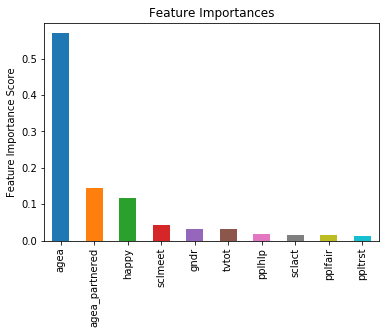

In [769]:
predictors = [x for x in X_train3.columns if x not in df[['partner', 'cntry', 'year', 'idno', 'agea_single', 'agea_under_20', 'agea_20_29', 'agea_30_39', 'agea_40_49', 'agea_50_59', 'agea_60_69', 'agea_70_79', 'agea_80_89', 'agea_90_99', 'agea_over_100']]]
gbm_tuned_2 = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='deviance', max_depth=3,
               max_features=0.6, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=8,
               min_weight_fraction_leaf=0.0, n_estimators=184,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False)
modelfit2(gbm_tuned_2, df, predictors)

In [770]:
# We'll make 76 iterations, use 4-deep trees, and set our loss function.
# https://machinelearningmastery.com/configure-gradient-boosting-algorithm/
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

params3 = {'criterion':'friedman_mse',
           'init': None,
           'learning_rate': 0.05,
           'loss': 'deviance',
           'max_depth': 3,
           'max_features':.6,
           'max_leaf_nodes': None,
           'min_impurity_decrease': 0.0, 'min_impurity_split': None,
            'min_samples_leaf': 1, 'min_samples_split': 8,
            'min_weight_fraction_leaf': 0.0, 'n_estimators': 184,
            'n_iter_no_change': None, 'presort': 'auto', 'random_state': 10,
            'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1,
             'verbose': 0, 'warm_start': False}

# Initialize and fit the model.
clf3 = ensemble.GradientBoostingClassifier(**params3)
clf3.fit(X_train3, y_train3)

predict_train3 = clf3.predict(X_train3)
predict_test3 = clf3.predict(X_test3)

# Accuracy tables.
table_train3 = pd.crosstab(y_train3, predict_train3, margins=True)
table_test3 = pd.crosstab(y_test, predict_test3, margins=True)

train_tI_errors3 = table_train3.loc[0.0,1.0] / table_train3.loc['All','All']
train_tII_errors3 = table_train3.loc[1.0,0.0] / table_train3.loc['All','All']

test_tI_errors3 = table_test3.loc[0.0,1.0]/table_test3.loc['All','All']
test_tII_errors3 = table_test3.loc[1.0,0.0]/table_test3.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors  (False POS): {}\n'
    'Percent Type II errors (False NEG): {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors  (False POS): {}\n'
    'Percent Type II errors (False NEG): {}'
).format(train_tI_errors3, train_tII_errors3, test_tI_errors3, test_tII_errors3))


Training set accuracy:
Percent Type I errors  (False POS): 0.0447354064375341
Percent Type II errors (False NEG): 0.18385160938352427

Test set accuracy:
Percent Type I errors  (False POS): 0.053987730061349694
Percent Type II errors (False NEG): 0.19631901840490798


## Conclusion:

Tuning n_estimators (# of trees), max depth, num_samples_split increased accuracy. For some reason, tuning max_features and subsampling did not seem to improve accuracy.  

Prior to adding additional features, decreasing learning rate from .1 to .05 worsened Type I errors slightly and improved Type II errors slightly.

Choosing which learning rate may be guided by criteria of what's more important - fewer false positives or fewer false negatives.

Adding the additional feature (partnered feature) did not improve the accuracy - even when using a smaller learning rate of .05.

Additional testing with features that might affect liklihood of partnership - such as gender or religious affiliation - might be potential next steps.

Also, area to understand better: the importance of redistributing the feature imporantance so it's spread across more features. the value among variables.